In [1]:
import os#
#os.chdir('c:\\Users\\ma11115\\OneDrive - Imperial College London\\github_folder\\STK_SEARCH\\')
os.chdir("/rds/general/user/ma11115/home/STK_Search/STK_search")
from pathlib import Path#
import pandas as pd
import torch
import numpy as np
import importlib
from stk_search.utils import database_utils

os.makedirs('data/output/search_experiment/search_exp_database', exist_ok=True)

In [2]:
# run a search experiment with the new target
from stk_search.utils import run_hpc_utils
importlib.reload(run_hpc_utils)
df_total_path_bench = 'data/output/Full_dataset/df_train_pred_learned_better_format.csv'
df_precursor_path ="data/output/Prescursor_data/precursor_data_200324.pkl"
df_precursor_Mordred_path="data/output/Prescursor_data/df_PCA_mordred_descriptor_290224.pkl"

search_space_loc = "data/input/EXP_search_space/6_mers_filtered_BB_2024_05_15_09_28_21//search_space_0.pkl"#"data/input/EXP_search_space/6_frag_all_2024_05_11_22_40_37//search_space_0.pkl"

In [3]:
# load and check the search space
from stk_search import Search_space
search_space = pd.read_pickle(search_space_loc)
print(' Search space condition list:', search_space.conditions_list)
print('shape of df_precursors:', search_space.df_precursors.shape)
print('search space syntax:', search_space.syntax)


 Search space condition list: [[], [], [], [], [], []]
shape of df_precursors: (274, 49)
search space syntax: [0, 1, 2, 3, 4, 5]


In [4]:
# load and check the dataframe to search over and the df_precursors
df_Benchmark = pd.read_csv(df_total_path_bench)
df_precursor_Mordred = pd.read_pickle(df_precursor_Mordred_path)
df_precursors = pd.read_pickle(df_precursor_path)
print('shape of df_Benchmark:', df_Benchmark.shape)
print('shape of df_precursors:', df_precursors.shape)
print('shape of df_precursor_Mordred:', df_precursor_Mordred.shape)
print(df_Benchmark[df_Benchmark['target']>0].shape[0]/df_Benchmark.shape[0])

shape of df_Benchmark: (89856, 9)
shape of df_precursors: (306, 40)
shape of df_precursor_Mordred: (312, 101)
0.0001558048433048433


In [5]:
num_of_elem_in_SP = search_space.check_df_for_element_from_SP(df_Benchmark).shape
print('number of elements in the benchmark in the search space:', num_of_elem_in_SP)

number of elements in the benchmark in the search space: (46892, 9)


In [6]:
# set the benchmark parameters  
exp_name = "Benchmark_56K_dataset"
num_elem_initialisation=5
num_iteration=500
target = 'target'
aim = 'maximise'
case_name_list = ["ea_surrogate_new", "BO_learned_new"] # ['evolution_algorithm','random','BO_precursor']#,["ea_surrogate_new", "BO_learned_new"] # "ea_surrogate", "BO_learned"
config_dir_list = ["/rds/general/user/ma11115/home/STK_Search/STK_search/data/representation_learning/6-frag/target/240322/SchNet/splitrand-nummol50000"]
config_dir_list_new = [f"/rds/general/user/ma11115/home/STK_Search/STK_search/data/representation_learning/6-frag/target/240516/SchNet/splitrand-nummol{num_mol}" for num_mol in [10000]]

In [7]:
#importlib.reload(MultifidelityBayesianOptimisation)

def run_search_on_hpc(
    case_name="ea_surrogate",
    df_path_total=df_total_path_bench,
    df_precursors_path=df_precursor_path,
    frag_properties="selected",
    config_dir="",
    dataset_representation_path = None,
    test=False,
    lim_counter = 5,
    which_acquisition = "EI",
    budget =100,

):
    string_to_run_notebook, script_qsub = run_hpc_utils.generate_string_run(
        case=case_name,
        target=target,
        aim=aim,
        num_elem_initialisation=num_elem_initialisation,
        num_iteration=num_iteration,
        df_path=df_path_total,
        benchmark=True,
        test_name=exp_name,
        df_precursors_path=df_precursors_path,
        frag_properties=frag_properties,
        config_dir=config_dir,
        dataset_representation_path=dataset_representation_path,
        lim_counter = lim_counter,
        which_acquisition = which_acquisition,
        search_space_loc = search_space_loc,
        budget = budget
    )
    if test:
        %run {string_to_run_notebook}
        return string_to_run_notebook
    run_hpc_utils.submit_job(script_qsub, case_name)




In [24]:
#importlib.reload(Look_up_table)

run_search_on_hpc(
                case_name='MFBO',
                df_precursors_path=df_precursor_path,
                which_acquisition = "KG",
                test=True,
                budget =100,   
            )

src/dev_scripts/run_search_new.py  --case MFBO --test_name Benchmark_56K_dataset --target target --aim maximise --benchmark 1 --num_iteration 500 --num_elem_initialisation 50 --which_acquisition KG --dataset_representation_path None --df_path data/output/Full_dataset/df_train_pred_learned_better_format.csv --df_precursors_path data/output/Prescursor_data/precursor_data_200324.pkl --search_space_loc /rds/general/user/ma11115/home/STK_Search/STK_search/data/input/search_space/test/search_space1.pkl --frag_properties selected --lim_counter 5 --budget 100
 number of fragment 6
True benchmark
MFBO   case  
Index(['Atom_num', 'HOMO (eV)', 'LUMO (eV)', 'HOMO_LUMO_GAP (eV)', 'IP (eV)',
       'EA (eV)', '1 Excited state Energy (eV)', '1 Excited state Osc',
       '2 Excited state Energy (eV)', '2 Excited state Osc',
       '3 Excited state Energy (eV)', '3 Excited state Osc'],
      dtype='object')
Inputs saved.
element Inchikey suggested: KTIVSVNWJQKONM-HXMJVOLOSA-N, Eval: -3.6119442
fitness 

/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/botorch/models/gpytorch.py:99: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(


KeyboardInterrupt: 

'src/dev_scripts/run_search_new.py  --case MFBO --test_name Benchmark_56K_dataset --target target --aim maximise --benchmark 1 --num_iteration 500 --num_elem_initialisation 50 --which_acquisition KG --dataset_representation_path None --df_path data/output/Full_dataset/df_train_pred_learned_better_format.csv --df_precursors_path data/output/Prescursor_data/precursor_data_200324.pkl --search_space_loc /rds/general/user/ma11115/home/STK_Search/STK_search/data/input/search_space/test/search_space1.pkl --frag_properties selected --lim_counter 5 --budget 100'

<Figure size 640x480 with 0 Axes>

In [15]:

import glob
import pickle
import json
def load_search_list(df):
    search_list = []
    for index, row in df.iterrows():
        search_list.append(pickle.load(open(row['search_exp_file'], "rb")))
    return search_list
save_path = f"data/output/search_experiment/search_exp_database"
json_files = glob.glob(f"{save_path}/*.json")
list_json = []
for json_file in json_files:
    with open(json_file, 'r') as f:
        list_json.append(json.load(f))
    f.close()
df = pd.DataFrame(list_json)
df['search_exp_file'] = df['search_output_folder']+"/"+df['date']+"/results_"+df['run_search_name']+'.pkl'
df = df[df['benchmark']]
print(df.shape)
df_all = df.copy()
df_all.head()


(2661, 22)


,num_iteration,num_elem_initialisation,test_name,case,target_name,config_dir,aim,which_acquisition,lim_counter,search_space_loc,...,df_precursors_path,benchmark,dataset_representation_path,frag_properties,run_search_name,search_output_folder,date,git_version,budget,search_exp_file
1,500,50,Benchmark_56K_dataset,BO_precursor,target,,maximise,EI,5,/rds/general/user/ma11115/home/STK_Search/STK_...,...,data/output/Prescursor_data/precursor_data_200...,True,None,selected,a7ebd9293ec84c7c8e118bfb8b1c234e,data/output/search_experiment/6_frag/Benchmark...,20240516,e5c60ca4e136ee47e25bbaa7e455f565895b70c3,NaN,data/output/search_experiment/6_frag/Benchmark...
2,300,50,new_target,ea_surrogate,target,/rds/general/user/ma11115/home/STK_Search/STK_...,None,EI,10,/rds/general/user/ma11115/home/STK_Search/STK_...,...,data/output/Prescursor_data/calculation_data_p...,True,/rds/general/ephemeral/user/ma11115/ephemeral/...,all,ac97e57ea5cf4449a242bc02251a0e62,data/output/search_experiment/6_frag/new_target,20240323,e5c60ca4e136ee47e25bbaa7e455f565895b70c3,NaN,data/output/search_experiment/6_frag/new_targe...
3,300,50,frag_prop,BO_precursor,target,/rds/general/user/ma11115/home/STK_Search/STK_...,0.0,EI,10,/rds/general/user/ma11115/home/STK_Search/STK_...,...,/rds/general/user/ma11115/home/STK_Search/STK_...,True,/rds/general/user/ma11115/home/STK_Search/STK_...,all,ddb27e04633545739bbfadba54b279e3,data/output/search_experiment/6_frag/frag_prop,20240308,e5c60ca4e136ee47e25bbaa7e455f565895b70c3,NaN,data/output/search_experiment/6_frag/frag_prop...
4,500,50,Benchmark_75K_dataset,ea_surrogate_new,target,/rds/general/user/ma11115/home/STK_Search/STK_...,maximise,EI,5,/rds/general/user/ma11115/home/STK_Search/STK_...,...,data/output/Prescursor_data/precursor_data_200...,True,None,selected,29aa2aea54e243ac9ca7f0a302160199,data/output/search_experiment/6_frag/Benchmark...,20240512,e5c60ca4e136ee47e25bbaa7e455f565895b70c3,NaN,data/output/search_experiment/6_frag/Benchmark...
5,300,50,different_representations_dataset,ea_surrogate,target,/rds/general/user/ma11115/home/STK_Search/STK_...,None,EI,10,/rds/general/user/ma11115/home/STK_Search/STK_...,...,data/output/Prescursor_data/calculation_data_p...,True,/rds/general/ephemeral/user/ma11115/ephemeral/...,all,cf384899f2ed49d298302d960a2352c7,data/output/search_experiment/6_frag/different...,20240322,e5c60ca4e136ee47e25bbaa7e455f565895b70c3,NaN,data/output/search_experiment/6_frag/different...


In [16]:
num_iteration = 500
num_elem_initialisation = 50
oligomer_size = 6 
search_space_loc = '/rds/general/user/ma11115/home/STK_Search/STK_search/data/input/search_space/test/search_space1.pkl'
#df_filtered = df_all[df_all['num_iteration']==num_iteration]
#df_filtered = df_filtered[df_filtered['num_elem_initialisation']==num_elem_initialisation]
df_filtered = df_all[df_all['df_path']==df_total_path_bench]

df_filtered = df_filtered[df_filtered['oligomer_size']==oligomer_size]
print(df_filtered.shape)

print(df_filtered.shape)
df_list = df_filtered.groupby(['case','frag_properties','which_acquisition','config_dir','df_path','df_precursors_path',])
print(len(df_list))
df_list.describe()

(11, 22)
(11, 22)
2


num_iteration  \
                                                                                                                                                                                                        count   
case frag_properties which_acquisition config_dir                                         df_path                                            df_precursors_path                                                 
MFBO selected        EI                                                                   data/output/Full_dataset/df_train_pred_learned_... data/output/Prescursor_data/precursor_data_2003...           7.0   
                                       /rds/general/user/ma11115/home/STK_Search/STK_s... data/output/Full_dataset/df_train_pred_learned_... data/output/Prescursor_data/precursor_data_2003...           4.0   

                                                                                                                                                                                                        \
                                                                                                                                                                                                  mean   
case frag_properties which_acquisition config_dir                                         df_path                                            df_precursors_path                                          
MFBO selected        EI                                                                   data/output/Full_dataset/df_train_pred_learned_... data/output/Prescursor_data/precursor_data_2003...  500.0   
                                       /rds/general/user/ma11115/home/STK_Search/STK_s... data/output/Full_dataset/df_train_pred_learned_... data/output/Prescursor_data/precursor_data_2003...  500.0   

                                                                                                                                                                                                      \
                                                                                                                                                                                                 std   
case frag_properties which_acquisition config_dir                                         df_path                                            df_precursors_path                                        
MFBO selected        EI                                                                   data/output/Full_dataset/df_train_pred_learned_... data/output/Prescursor_data/precursor_data_2003...  0.0   
                                       /rds/general/user/ma11115/home/STK_Search/STK_s... data/output/Full_dataset/df_train_pred_learned_... data/output/Prescursor_data/precursor_data_2003...  0.0   

                                                                                                                                                                                                        \
                                                                                                                                                                                                   min   
case frag_properties which_acquisition config_dir                                         df_path                                            df_precursors_path                                          
MFBO selected        EI                                                                   data/output/Full_dataset/df_train_pred_learned_... data/output/Prescursor_data/precursor_data_2003...  500.0   
                                       /rds/general/user/ma11115/home/STK_Search/STK_s... data/output/Full_dataset/df_train_pred_learned_... data/output/Prescursor_data/precursor_data_2003...  500.0   

                                                                                                                           

In [17]:
import pandas as pd
def join_name(x):
    return '*'.join(x)

def load_search_list(df,min_num_iteration):
    search_list = []
    for index, row in df.iterrows():
        if min_num_iteration <= row['max_num_eval']:
            search_list.append(pd.read_pickle(row['search_exp_file']))
    return search_list
def get_results_length(x):
    try:
        return len(pd.read_pickle(x)['fitness_acquired'])
    except Exception as e:
        #print(e)
        return 0
results_dict = {}
num_searches_with_min, df_plot_dict = {}, {}
min_num_iteration = 5
for name , df in df_list:
    if len(df) != 0: 
        df['max_num_eval']=df['search_exp_file'].apply(lambda x: get_results_length(x))
        key = join_name(name)
        df['key'] = key
        if df['max_num_eval'].max() >= min_num_iteration:
            results_dict[key] = load_search_list(df,min_num_iteration)
            num_searches_with_min[key] = (len(results_dict[key]), df['df_path'].values[0])
df_summary_1 = pd.DataFrame.from_dict(num_searches_with_min, orient='index',columns=['number of explorations with min iterations','df_path'])
df_summary_1['key'] = df_summary_1.index    
df_summary_1['case'] = df_summary_1['key'].apply(lambda x: x.split('*')[0])
df_summary_1['num_mol_training'] = df_summary_1['key'].apply(lambda x: x.split('nummol')[-1])

df_summary_1['which_acquisition'] = df_summary_1['key'].apply(lambda x: x.split('*')[2])
df_summary_1.reset_index(inplace=True)
df_summary_1

,index,number of explorations with min iterations,df_path,key,case,num_mol_training,which_acquisition
0,MFBO*selected*EI**data/output/Full_dataset/df_...,2,data/output/Full_dataset/df_train_pred_learned...,MFBO*selected*EI**data/output/Full_dataset/df_...,MFBO,MFBO*selected*EI**data/output/Full_dataset/df_...,EI
1,MFBO*selected*EI*/rds/general/user/ma11115/hom...,1,data/output/Full_dataset/df_train_pred_learned...,MFBO*selected*EI*/rds/general/user/ma11115/hom...,MFBO,10000*data/output/Full_dataset/df_train_pred_l...,EI


In [18]:
for keys in df_summary_1['key']:
    print(keys)
    print(len(results_dict[keys]))
    res = results_dict[keys]

MFBO*selected*EI**data/output/Full_dataset/df_train_pred_learned_better_format.csv*data/output/Prescursor_data/precursor_data_200324.pkl
2
MFBO*selected*EI*/rds/general/user/ma11115/home/STK_Search/STK_search/data/representation_learning/6-frag/target/240516/SchNet/splitrand-nummol10000*data/output/Full_dataset/df_train_pred_learned_better_format.csv*data/output/Prescursor_data/precursor_data_200324.pkl
1


In [19]:
res[0]['searched_space_df']

,InChIKey_0,InChIKey_1,InChIKey_2,InChIKey_3,InChIKey_4,InChIKey_5,fidelity
0,SOESJFVMGGQDFQ-UHFFFAOYSA-N,BHOSZUQMOQVQOO-UHFFFAOYSA-N,HFUBKQHDPJZQIW-UHFFFAOYSA-N,WNSNPGHNIJOOPM-UHFFFAOYSA-N,YYTSOZXMJUHWJS-UHFFFAOYSA-N,SJXHQUBNLYQDRD-UHFFFAOYSA-N,1.0
1,WVGHJMFKJADIAM-UHFFFAOYSA-N,UVCFYBOLMFIWGF-FPYGCLRLSA-N,HFUBKQHDPJZQIW-UHFFFAOYSA-N,ZHXUWDPHUQHFOV-UHFFFAOYSA-N,YYTSOZXMJUHWJS-UHFFFAOYSA-N,ZIPLQQUKMANDSU-UHFFFAOYSA-N,1.0
2,YYTSOZXMJUHWJS-UHFFFAOYSA-N,LXPGOLVTQAXCFY-UHFFFAOYSA-N,ZHXUWDPHUQHFOV-UHFFFAOYSA-N,ZHXUWDPHUQHFOV-UHFFFAOYSA-N,LXPGOLVTQAXCFY-UHFFFAOYSA-N,YYTSOZXMJUHWJS-UHFFFAOYSA-N,0.5
3,ZSOUNTXQXDIRIZ-UHFFFAOYSA-N,NWVJJPFAYZRFBC-UHFFFAOYSA-N,FDAZPZADKYHVQQ-NSIKDUERSA-N,MTLFYGNDDYBIIU-JYOAFUTRSA-N,NWVJJPFAYZRFBC-UHFFFAOYSA-N,ZSOUNTXQXDIRIZ-UHFFFAOYSA-N,0.5
4,NACLVJFIPGLGGF-UHFFFAOYSA-N,NACLVJFIPGLGGF-UHFFFAOYSA-N,XJDUSLLTQXVMPI-UHFFFAOYSA-N,XJDUSLLTQXVMPI-UHFFFAOYSA-N,KESGZSFJWVCXKF-UHFFFAOYSA-N,NACLVJFIPGLGGF-UHFFFAOYSA-N,1.0
...,...,...,...,...,...,...,...
121,HNRHIGPDSSXEJA-FARCUNLSSA-N,YYTSOZXMJUHWJS-UHFFFAOYSA-N,YYTSOZXMJUHWJS-UHFFFAOYSA-N,ZHXUWDPHUQHFOV-UHFFFAOYSA-N,YYTSOZXMJUHWJS-UHFFFAOYSA-N,YYTSOZXMJUHWJS-UHFFFAOYSA-N,0.5
122,YYTSOZXMJUHWJS-UHFFFAOYSA-N,ZHXUWDPHUQHFOV-UHFFFAOYSA-N,ZHXUWDPHUQHFOV-UHFFFAOYSA-N,ZHXUWDPHUQHFOV-UHFFFAOYSA-N,MRBCQJMEGDDUNN-WMZJFQQLSA-N,YYTSOZXMJUHWJS-UHFFFAOYSA-N,0.5
123,YYTSOZXMJUHWJS-UHFFFAOYSA-N,ZHXUWDPHUQHFOV-UHFFFAOYSA-N,YYTSOZXMJUHWJS-UHFFFAOYSA-N,LXPGOLVTQAXCFY-UHFFFAOYSA-N,YYTSOZXMJUHWJS-UHFFFAOYSA-N,ZHXUWDPHUQHFOV-UHFFFAOYSA-N,0.5
124,LXPGOLVTQAXCFY-UHFFFAOYSA-N,YYTSOZXMJUHWJS-UHFFFAOYSA-N,AEXMFBWMBBWABJ-AOOOYVTPSA-N,ZHXUWDPHUQHFOV-UHFFFAOYSA-N,YYTSOZXMJUHWJS-UHFFFAOYSA-N,LXPGOLVTQAXCFY-UHFFFAOYSA-N,0.5


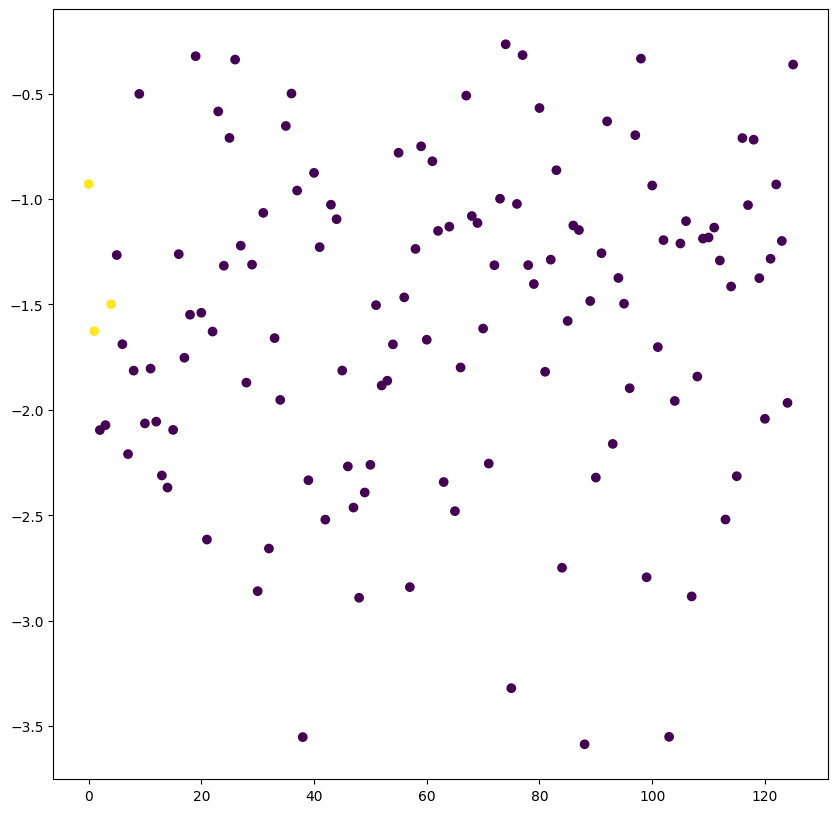

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
fig,ax = plt.subplots(1,1,figsize=(10,10))
ax.scatter(x=res[0]['ids_acquired'],y = res[0]['fitness_acquired'],c =res[0]['searched_space_df']['fidelity'])


In [21]:
## test mfbo acquisition function


In [33]:
from stk_search.Search_algorithm import MultifidelityBayesianOptimisation
from stk_search.Representation import (
    Representation_from_fragment,
    Representation_3d_from_fragment,
)
MFBO = MultifidelityBayesianOptimisation.MultifidelityBayesianOptimisation(
            budget=100, 
            which_acquisition='KG', 
            lim_counter=5)

frag_properties = []
frag_properties = df_precursors.columns[1:7]
frag_properties = frag_properties.append(
    df_precursors.columns[17:23]
)

print(frag_properties)
MFBO.Representation = (
    Representation_from_fragment.Representation_from_fragment(
        df_precursors, frag_properties
    )
)
search_algorithm = MFBO

Index(['Atom_num', 'HOMO (eV)', 'LUMO (eV)', 'HOMO_LUMO_GAP (eV)', 'IP (eV)',
       'EA (eV)', '1 Excited state Energy (eV)', '1 Excited state Osc',
       '2 Excited state Energy (eV)', '2 Excited state Osc',
       '3 Excited state Energy (eV)', '3 Excited state Osc'],
      dtype='object')


In [34]:
from stk_search import Search_Exp
from stk_search.Objective_function import Look_up_table
objective_function = Look_up_table(
            df_Benchmark, oligomer_size, target_name='target', aim=aim
        )

number_of_iterations = num_iteration
verbose = True
num_elem_initialisation = 50
S_exp = Search_Exp.Search_exp(
    search_space_loc,
    search_algorithm,
    objective_function,
    number_of_iterations,
    verbose=verbose,
)

S_exp.num_elem_initialisation = num_elem_initialisation
S_exp.benchmark = True
S_exp.df_total = df_Benchmark
# S_exp.df_precur


In [35]:
S_exp.initialise_search_space()  # the initialisation of the space here makes it too rigid to change it without saving a new search_space
        # get initial elements
ids_acquired, df_search_space = (
    S_exp.search_algorithm.initial_suggestion(
        SP=S_exp.search_space,
        num_elem_initialisation=S_exp.num_elem_initialisation,
        benchmark=S_exp.benchmark,
        df_total=S_exp.df_total,
    )
)
if (S_exp.search_algorithm.budget is not None) and (S_exp.search_algorithm.budget < 0): 
    raise Exception('Budget exhausted by Initial Sample')
        
S_exp.df_search_space = df_search_space
for id in range(S_exp.num_elem_initialisation):
    # evaluate the element
    S_exp.evaluate_element(
        element_id=ids_acquired[id],
        objective_function=S_exp.objective_function,
    )
if S_exp.verbose:
    print(f"max fitness acquired: {max(S_exp.fitness_acquired)}")
    print(f"min fitness acquired: {min(S_exp.fitness_acquired)}")

element Inchikey suggested: RMWOKJDGVSJRDC-HTVDVWKISA-N, Eval: -1.8623954
fitness suggested: 0    0.5
Name: fidelity, dtype: float64
element Inchikey suggested: SFBOLXOEVSWZAH-UHFFFAOYSA-N, Eval: -0.532509612
fitness suggested: 1    1.0
Name: fidelity, dtype: float64
element Inchikey suggested: HRODQTOPEVBJIA-UHFFFAOYSA-N, Eval: -2.1782637
fitness suggested: 2    0.5
Name: fidelity, dtype: float64
element Inchikey suggested: CYFSDEUTYHZCGO-UODXMUSUSA-N, Eval: -1.5595433
fitness suggested: 3    0.5
Name: fidelity, dtype: float64
element Inchikey suggested: OGEWIXMZYZEQSN-UHFFFAOYSA-N, Eval: -2.640987314
fitness suggested: 4    1.0
Name: fidelity, dtype: float64
element Inchikey suggested: YYIQGYAWXKJUQZ-GFDBJVIDSA-N, Eval: -2.7949808
fitness suggested: 5    0.5
Name: fidelity, dtype: float64
element Inchikey suggested: OTJVQPKHURPPIW-KVHFJQDISA-N, Eval: -2.0785718
fitness suggested: 6    0.5
Name: fidelity, dtype: float64
element Inchikey suggested: JXEODDSKJOBLKZ-UHFFFAOYSA-N, Eval: -1

In [37]:

def suggest_element(
        S_exp.search_algorithm,
        S_exp.search_space_df,
        S_exp.fitness_acquired,
        S_exp.ids_acquired,
        S_exp.SP,
        S_exp.benchmark,
        S_exp.df_total,
    ):
        """Suggest a new element to evaluate.
        Args:
            search_space_df (pd.DataFrame): search space
            fitness_acquired (list): fitness of the acquired elements
            ids_acquired (list): ids of the acquired elements
            SP (Search_Space): search space
            benchmark (bool): if True, the search space is a benchmark
            df_total (pd.DataFrame): dataframe of the total dataset
        Returns:
            int: id of the new element
            pd.DataFrame: updated search space
        """
        df_search = S_exp.search_space_df.copy()
        fitness_acquired = np.array(S_exp.fitness_acquired)
        repr = df_search.loc[S_exp.ids_acquired, :]

        X_rpr = S_exp.search_algorithm.generate_rep_with_fidelity(repr)
        y_explored_BO_norm = torch.tensor(
            S_exp.fitness_acquired, dtype=torch.float64
        )
        y_explored_BO_norm = (
            y_explored_BO_norm - y_explored_BO_norm.mean(axis=0)
        ) / (y_explored_BO_norm.std(axis=0))
        y_explored_BO_norm = y_explored_BO_norm.reshape(-1, 1)

        # train model
        self.train_model(X_rpr, y_explored_BO_norm)
        # optimise the acquisition function
        ids_sorted_by_aquisition, df_elements = (
            self.optimise_acquisition_function(
                best_f=y_explored_BO_norm.max().item(),
                fitness_acquired=fitness_acquired,
                df_search=df_search,
                SP=SP,
                benchmark=benchmark,
                df_total=df_total,
            )
        )

        for element_id in ids_sorted_by_aquisition:
            if self.add_element(df_search, df_elements.values[element_id.item()]):
                break
        return len(df_search) - 1, df_search

SyntaxError: invalid syntax (4019462937.py, line 12)